In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('Memory growth enabled')
else:
    print('No memory growth!')

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras import Input
from keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D
from pathlib import Path
import utility as utils
from keras_segmentation.models.model_utils import get_segmentation_model, concatenate
from keras_segmentation.models.pspnet import pspnet


data_dir = Path('dataset/')
sun_dir = Path('sunrgb/')

rgb_dir = sun_dir / "rgb"
seg_dir = sun_dir / "seg"

train_img_dir = data_dir / "train" / 'rgb'
train_seg_dir = data_dir / "train" / 'seg'

val_img_dir = data_dir / "val" / 'rgb'
val_seg_dir = data_dir / "val" / 'seg'

test_img_dir = data_dir / "test" / 'rgb'
test_seg_dir = data_dir / "test" / 'seg'

check_dir = data_dir / "checkpoints" / "pspnet"

print(tf.version.VERSION)


2.1.0


In [6]:
EPOCHS = 10
BATCH_SIZE = 2

photo_size = (384, 576, 3)
number_classes = 38

from keras.optimizers import Adam

OPTIMIZER = Adam(learning_rate=1e-3)

base_model = pspnet(number_classes,
                    input_height=photo_size[0],
                    input_width=photo_size[1])

base_model.train(
    train_images=str(train_img_dir.resolve()),
    train_annotations=str(train_seg_dir.resolve()),
    checkpoints_path=str(check_dir.resolve()),
    val_images=val_img_dir,
    val_annotations=val_seg_dir,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    optimizer_name=OPTIMIZER,
    ignore_zero_class=True,
    verify_dataset=False)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[4,64,194,290] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv2d_13/convolution (defined at C:\Users\Cristiano\anaconda3\envs\ipcv_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_17488]

Function call stack:
keras_scratch_graph


In [7]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12

model = pspnet_50_ADE_20K() # load the pretrained model trained on ADE20k dataset

import random
import os

os.makedirs(data_dir / 'output', exist_ok=True)

187842560/187839752 [==============================] - 444s 2us/step

AssertionError: Input should be the CV image or the input file name

immagine di input =  img_08427
0.8409091781100483


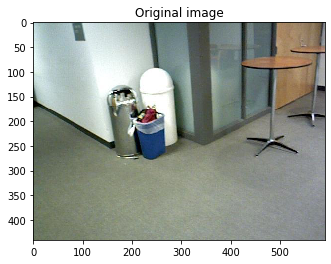

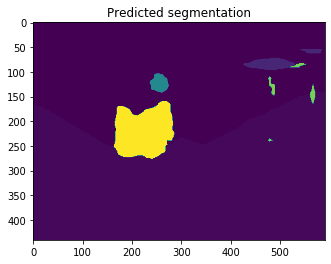

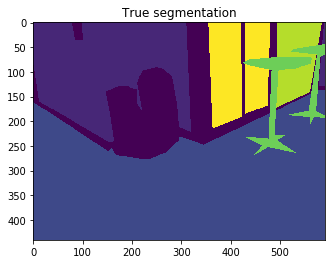

In [66]:
from skimage.transform import resize


out_file = data_dir / "output" / "output.png"
img_dir = val_img_dir
seg_dir = val_seg_dir
input_image = random.choice(list(img_dir.glob('*')))
true_seg = seg_dir / (input_image.stem + '.png')
print('immagine di input = ', input_image.stem)

prediction = model.predict_segmentation(
	inp=str(input_image.resolve()),
	out_fname=str(out_file.resolve()),
    # show_legends=True, class_names=l
)

original = plt.imread(str(input_image.resolve()))
true = plt.imread(str(true_seg.resolve()))

predicted = resize(prediction, true.shape)

plt.figure()
plt.imshow(original)
plt.title('Original image')
plt.figure()
plt.imshow(predicted)
plt.title('Predicted segmentation')
plt.figure()
plt.imshow(true)
plt.title('True segmentation')

def iou_coef(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

iou = iou_coef(true, predicted)
print(iou)

In [12]:
d = {0:'None',
    1:'wall',
2:'floor',
3:'cabinet',
4:'bed',
5:'chair',
6:'sofa',
7:'table',
8:'door',
9:'window',
10:'bookshelf',
11:'picture',
12:'counter',
13:'blinds',
14:'desk',
15:'shelves',
16:'curtain',
17:'dresser',
18:'pillow',
19:'mirror',
20:'floor_mat',
21:'clothes',
22:'ceiling',
23:'books',
24:'fridge',
25:'tv',
26:'paper',
27:'towel',
28:'shower_curtain',
29:'box',
30:'whiteboard',
31:'person',
32:'night_stand',
33:'toilet',
34:'sink',
35:'lamp',
36:'bathtub',
37:'bag'
}

l = [(k,v) for (k,v) in d.items()]